In [ ]:
import os
import json
import pickle
import collections

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from valerie.utils import get_logger, titleize, stats
from valerie.scoring import validate_predictions_phase2

In [2]:
def compute_score_phase2(labels, predictions):
    """
    predictions and labels are a dict
    check for duplicate relevant articles
    """
    n_class = collections.Counter([labels[o]["label"] for o in labels])
    scores = {"0": [], "1": [], "2": []}
    preds = []
    explanations = []
    if len(predictions) != len(labels):
        raise ValueError("prediction missing for some claims")
    # loop over predictions as the normalizing factor is n_class (# labels predicted)
    for claim_id in predictions:
        if len(predictions[claim_id]["explanation"]) > 1000:
            return {
                "score": 0.0,
                "explanation": "'N/S'",
                "error": "'MaxCharacterLimitError'",
                "predictions": "'N/A'",
            }
        pred = predictions[claim_id]["label"]
        preds.append(str(pred))
        label = labels[claim_id]["label"]
        if pred != label:
            scores[str(label)].append(0)
            continue
        rel_articles = list(predictions[claim_id]["related_articles"].values())
#         if len(rel_articles) > 2:
#             return {
#                 "score": 0.0,
#                 "explanation": "'N/S'",
#                 "error": "'MaxRelatedArticlesLimitError'",
#                 "predictions": "'N/A'",
#             }
        # remove any duplicate url links
        rel_articles = set(rel_articles)
        gt_rel_articles = list(labels[claim_id]["related_articles"].values())
        scores[str(label)].append(
            sum([int(a in gt_rel_articles) for a in rel_articles])
        )
        explanations.append(predictions[claim_id]["explanation"].replace("'", ""))

    for l in scores:
        if not scores[l]:  # if scores[l] is [], np.mean returns a NaN
            scores[l] = 0.0
        else:
            scores[l] = sum(scores[l]) / n_class[int(l)]

    return {
        "score": np.mean(list(scores.values())),
        "error": "'None'",
        "explanation": "'{}'".format("|".join(explanations)),
        "predictions": "'[{}]'".format(",".join(preds)),
    }

In [3]:
def compute_responses_score(responses, num_to_keep):
    predictions = {}
    perfect_predictions = {}
    labels = {}

    for v in responses:
        claim = v["claim"]
        labels[claim.id] = claim.to_dict()
        predictions[claim.id] = {
            "label": claim.label,
            "related_articles": {
                i + 1: x
                for i, x in enumerate(
                    [hit["url"] for hit in v["res"]["hits"]["hits"][:num_to_keep]]
                )
            }
            if v["res"]
            else {},
            "explanation": "",
        }
        perfect_predictions[claim.id] = {
            "label": claim.label,
            "related_articles": {
                i + 1: x
                for i, x in enumerate(
                    [
                        hit["url"]
                        for hit in v["res"]["hits"]["hits"]
                        if hit["url"] in claim.related_articles.values()
                    ][:num_to_keep]
                )
            }
            if v["res"]
            else {},
            "explanation": "",
        }

#     validate_predictions_phase2(predictions)
    score = compute_score_phase2(labels, predictions)
#     validate_predictions_phase2(perfect_predictions)
    perfect_score = compute_score_phase2(labels, perfect_predictions)
    return {
        "perfect_rerank_score": perfect_score["score"],
        "perfect_rerank_error": perfect_score["error"],
        "api_score": score["score"],
        "api_error": score["error"],
    }

In [10]:
def run_analysis(responses_file):
    print(titleize(responses_file))
    with open(responses_file, "rb") as fi:
        responses = pickle.load(fi)
    
    perfect_rerank_scores = []
    scores = []
    for i in range(30):
        _result = compute_responses_score(responses, i)
        perfect_rerank_scores.append(_result["perfect_rerank_score"])
        scores.append(_result["api_score"])

    print("--- perfect rerank stats ---")
    print(json.dumps(stats(perfect_rerank_scores), indent=2))
    print()
    
    print("--- scores stats ---")
    print(json.dumps(stats(scores), indent=2))
    print()
    
    print("--- numbers (n, perfect_rerank_score, api_score) ---")
    for i, (ps, s) in enumerate(zip(perfect_rerank_scores, scores)):
        print("{}\t{:.3f}\t{:.3f}".format(i, float(ps), float(s)))
    print()
    
    print("--- plot ---")
    plt.plot(list(range(30)), perfect_rerank_scores, label="perfect")
    plt.plot(list(range(30)), scores, label="api")
    plt.legend()
    plt.show()

# Results




--------------------------------------------------------------------------------
-------------------- data/phase2-3/processed/responses.pkl ---------------------
--------------------------------------------------------------------------------



--- perfect rerank stats ---
{
  "len": 30,
  "max": 1.1497376289000316,
  "min": 0.0,
  "mean": 1.0794536332416371,
  "median": 1.1497376289000316,
  "mode": 1.1497376289000316,
  "stdev": 0.22885466563356216
}

--- scores stats ---
{
  "len": 30,
  "max": 1.1485208467241774,
  "min": 0.0,
  "mean": 0.9013450534229778,
  "median": 0.9859167108194866,
  "mode": null,
  "stdev": 0.26863815897536464
}

--- numbers (n, perfect_rerank_score, api_score) ---
0	0.000	0.000
1	0.623	0.336
2	0.919	0.490
3	1.044	0.589
4	1.102	0.660
5	1.127	0.716
6	1.138	0.763
7	1.143	0.801
8	1.146	0.832
9	1.148	0.865
10	1.149	0.890
11	1.150	0.913
12	1.150	0.937
13	1.150	0.957
14	1.150	0.976
15	1.150	0.996
16	1.150	1.012
17	1.150	1.029
18	1.150	1.045
19	1.150	1.059
20	1

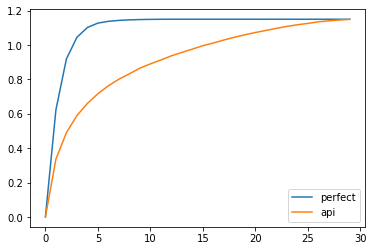




--------------------------------------------------------------------------------
-------------- data/phase2-validation-100/processed/responses.pkl --------------
--------------------------------------------------------------------------------



--- perfect rerank stats ---
{
  "len": 30,
  "max": 1.1444444444444444,
  "min": 0.0,
  "mean": 1.079021283727166,
  "median": 1.1444444444444444,
  "mode": 1.1444444444444444,
  "stdev": 0.2258470945344362
}

--- scores stats ---
{
  "len": 30,
  "max": 1.1444444444444444,
  "min": 0.0,
  "mean": 0.8811647394000335,
  "median": 0.9611362493715435,
  "mode": 0.9611362493715435,
  "stdev": 0.24832258830316345
}

--- numbers (n, perfect_rerank_score, api_score) ---
0	0.000	0.000
1	0.637	0.334
2	0.962	0.578
3	1.069	0.640
4	1.112	0.712
5	1.131	0.746
6	1.138	0.766
7	1.144	0.781
8	1.144	0.809
9	1.144	0.822
10	1.144	0.852
11	1.144	0.903
12	1.144	0.909
13	1.144	0.931
14	1.144	0.961
15	1.144	0.961
16	1.144	0.961
17	1.144	0.961
18	1.144	0.989
19	1.14

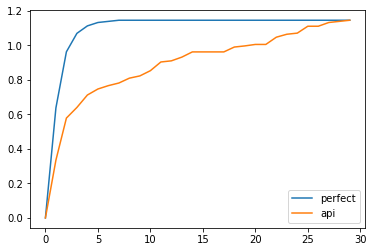




--------------------------------------------------------------------------------
-------------- data/phase2-validation-100/processed/responses.pkl --------------
--------------------------------------------------------------------------------



--- perfect rerank stats ---
{
  "len": 30,
  "max": 1.1444444444444444,
  "min": 0.0,
  "mean": 1.079021283727166,
  "median": 1.1444444444444444,
  "mode": 1.1444444444444444,
  "stdev": 0.2258470945344362
}

--- scores stats ---
{
  "len": 30,
  "max": 1.1444444444444444,
  "min": 0.0,
  "mean": 0.8811647394000335,
  "median": 0.9611362493715435,
  "mode": 0.9611362493715435,
  "stdev": 0.24832258830316345
}

--- numbers (n, perfect_rerank_score, api_score) ---
0	0.000	0.000
1	0.637	0.334
2	0.962	0.578
3	1.069	0.640
4	1.112	0.712
5	1.131	0.746
6	1.138	0.766
7	1.144	0.781
8	1.144	0.809
9	1.144	0.822
10	1.144	0.852
11	1.144	0.903
12	1.144	0.909
13	1.144	0.931
14	1.144	0.961
15	1.144	0.961
16	1.144	0.961
17	1.144	0.961
18	1.144	0.989
19	1.14

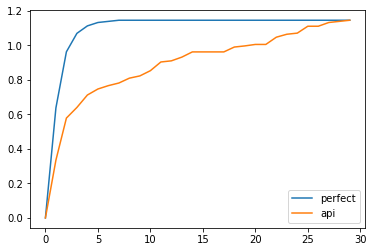




--------------------------------------------------------------------------------
------------------ data/phase2-trial/processed/responses.pkl -------------------
--------------------------------------------------------------------------------



--- perfect rerank stats ---
{
  "len": 30,
  "max": 1.5220469873871671,
  "min": 0.0,
  "mean": 1.4291952781683206,
  "median": 1.5220469873871671,
  "mode": 1.5220469873871671,
  "stdev": 0.30896492598425795
}

--- scores stats ---
{
  "len": 30,
  "max": 1.5132750575626055,
  "min": 0.0,
  "mean": 1.23402714102329,
  "median": 1.3919911567536731,
  "mode": null,
  "stdev": 0.36473179204191
}

--- numbers (n, perfect_rerank_score, api_score) ---
0	0.000	0.000
1	0.763	0.402
2	1.179	0.601
3	1.401	0.779
4	1.482	0.872
5	1.522	1.026
6	1.522	1.094
7	1.522	1.199
8	1.522	1.225
9	1.522	1.233
10	1.522	1.274
11	1.522	1.314
12	1.522	1.355
13	1.522	1.379
14	1.522	1.388
15	1.522	1.396
16	1.522	1.405
17	1.522	1.430
18	1.522	1.448
19	1.522	1.448
20	1.522	

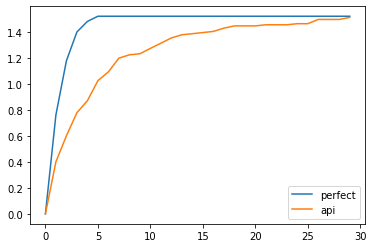

In [11]:
files_to_run = [
    "data/phase2-3/processed/responses.pkl", 
    "data/phase2-validation-100/processed/responses.pkl", 
    "data/phase2-validation-500/processed/responses.pkl",
    "data/phase2-trial/processed/responses.pkl"
]
for file_to_run in files_to_run:
    run_analysis(file_to_run)